In [1]:
import sys,os
sys.path.append('/home/marc/flow_ssl/')
import glob
import torch,dill
import torchvision.utils as vutils
import matplotlib.pyplot as plt
#from invertible.iresnet import iResBlock
from flow_ssl.invertible import SN
import torch.nn as nn
import torch.nn.functional as F
import scipy as sp
import numpy as np
import seaborn as sb
import pandas as pd
%load_ext line_profiler
torch.backends.cudnn.enabled = False

In [24]:
paths = glob.glob(os.path.expanduser('~/tb-experiments/elu_flow_full_slrelu2/**/*.trainer'),recursive=True)#glob.glob(os.path.expanduser('~/tb-experiments/iresnet_WTW/**/*.trainer'),recursive=True)
#paths = glob.glob(os.path.expanduser('~/tb-experiments/ielu100_iSLReLU_nodev/**/*.trainer'),recursive=True)
paths = glob.glob(os.path.expanduser('~/tb-experiments/slrelu2_3d_NN/**/*.trainer'),recursive=True)
paths = glob.glob(os.path.expanduser('~/tb-experiments/lrelu_test_logdet_invertible/CIFAR10/DegredationTester/**/*.trainer'),recursive=True)
paths = glob.glob(os.path.expanduser('~/tb-experiments/multiscale_icnnv2_ld/**/*.trainer'),recursive=True)

print(paths)

['/home/marc/tb-experiments/multiscale_icnnv2_ld/CIFAR10/MultiScaleiCNNv2/trial0/checkpoints/c1.trainer']


In [3]:
import os
import torch
import torch.nn as nn
from oil.datasetup.datasets import CIFAR10,CIFAR100
from oil.model_trainers.classifier import Classifier,simpleClassifierTrial
# from resnets import SplitODEResnet,ODEResnet,LongResnet,RNNBottle
# from resnets import SmallResnet,RNNResnet
from oil.tuning.study import Study, train_trial
from oil.utils.utils import Named,Expression
from flow_ssl.invertible import iConv2d,iSLReLU,SqueezeLayer,ClippediConv2d,iSequential,ActNorm
from flow_ssl.invertible import SqueezeLayer,padChannels,keepChannels,NNdownsample,iAvgPool2d,Flatten,iLeakyReLU
from flow_ssl.invertible import iLogits, iBN, MeanOnlyBN, passThrough, addZslot, Join, pad_circular_nd
from flow_ssl.icnn.icnn import StandardNormal,FlowNetwork
# from oil.tuning.configGenerator import uniform,logUniform

# log_dir_base = os.path.expanduser('~/tb-experiments/degradation_test')
# cfg_spec = {
#     'dataset': CIFAR10,
#     'network': [DegredationTester],
#     'net_config': [ {},
#                     {'circ':True},
#                     {'circ':True,'slrelu':True},
#                     {'circ':True,'slrelu':True,'ds':'checkerboard'},
#                     {'circ':True,'slrelu':True,'ds':'nn'},
#                     {'circ':True,'slrelu':True,'ds':'avg'},
#                     ],#k=128
#     'loader_config': {'amnt_dev':0,'lab_BS':50},
#     'opt_config':{'lr':.1},
#     'num_epochs':100, 
#     'trainer_config':{'log_dir':lambda cfg:log_dir_base+\
#         '/{}/{}'.format(cfg['dataset'],cfg['network'])}
#     }
#'log_dir':lambda cfg:f'{log_dir_base}/{cfg['dataset']}/{cfg['network']}/s{cfg['net_config']['sigma']}'
#ODEResnet,RNNResnet,,SplitODEResnet,SmallResnet,BezierRNNSplit,BezierODE,BezierRNN

class DegredationTester(FlowNetwork):
    def __init__(self, num_classes=10,k=128,circ=False,slrelu=False,lrelu=None,clip=(.01,None),ds='max'):
        super().__init__()
        self.num_classes = num_classes
        self.k = k
        
        conv = lambda c1,c2: ClippediConv2d(c1,c2,clip=clip,circ=circ)#iConv2d(c1,c2,circ=circ)#ClippediConv2d(c1,c2,clip=clip,circ=circ)#iConv2d(c1,c2,circ=circ)
        BN = iBN#lambda c: nn.Sequential()#ActNorm##lambda c: nn.BatchNorm2d(c)#Expression(lambda x:x)#nn.BatchNorm2d(c)#Expression(lambda x:x)#nn.Sequential()#nn.BatchNorm2d#ActNorm#nn.BatchNorm2d
        relu = iSLReLU if slrelu else nn.ReLU
        if lrelu is not None: relu = lambda: iLeakyReLU(lrelu)
        if ds=='max': downsample = lambda: nn.MaxPool2d(2)
        elif ds=='checkerboard': downsample = lambda: SqueezeLayer(2)
        elif ds=='nn': downsample = lambda: NNdownsample()
        elif ds=='avg': downsample = lambda: iAvgPool2d()
        else: assert False, "unknown option"
        CBR = lambda c1,c2: iSequential(conv(c1,c2),BN(c2),relu())
        self.body = iSequential(
            padChannels(k-3),
            addZslot(),
            passThrough(*[CBR(k,k) for _ in range(3)]),
            passThrough(downsample()),
            keepChannels(2*k),
            passThrough(*[CBR(2*k,2*k) for _ in range(3)]),
            passThrough(downsample()),
            keepChannels(2*k),
            passThrough(*[CBR(2*k,2*k) for _ in range(3)]),
            Join()
        )
        self.classifier_head = nn.Sequential(
            Expression(lambda z:z[-1]),
            Expression(lambda u:u.mean(-1).mean(-1)),
            nn.BatchNorm1d(2*k),
            nn.Linear(2*k,num_classes)
        )
        self.flow = iSequential(iLogits(),self.body,Flatten())
        self.prior = StandardNormal(k*32*32)

In [25]:

# import os
# from oil.datasetup.datasets import CIFAR10,CIFAR100
# from oil.model_trainers.classifier import Classifier,simpleClassifierTrial
# # from resnets import SplitODEResnet,ODEResnet,LongResnet,RNNBottle
# # from resnets import SmallResnet,RNNResnet
# from invertible.iEluNetwork import iEluNet,iEluNetMultiScaleLarger,iEluNet3d
# from oil.tuning.study import Study, train_trial

# from torch.utils.data import DataLoader
# from oil.utils.utils import LoaderTo, cosLr, recursively_update,islice
# from oil.tuning.study import train_trial
# from oil.datasetup.dataloaders import getLabLoader
# from oil.datasetup.datasets import CIFAR10
# from oil.architectures.img_classifiers import layer13s
# from invertible.iresnet import iResnet,iResnetLarge
# import collections
# trainset = CIFAR10('~/datasets/{}/'.format(CIFAR10))
# device = torch.device('cuda')
# fullCNN = iEluNet3d(num_classes=trainset.num_classes,k=32).to(device)
        
# dataloaders = {}
# dataloaders['train'], dataloaders['dev'] = getLabLoader(trainset,amnt_dev=0,lab_BS=64)
# dataloaders = {k:LoaderTo(v,device) for k,v in dataloaders.items()}
# trainer = Classifier(fullCNN,dataloaders)
# trainer.model.eval();
trainer = torch.load(paths[-1],pickle_module=dill)
trainer.model.eval();

In [26]:
#trainer = torch.load(paths[1],pickle_module=dill)
trainer.model.eval();

In [20]:
def eigh(mat):
    #print(mat.shape)
    return sp.linalg.eigh(mat,eigvals_only=True)

def singularValues(kernel,input_shape):
    transforms = np.fft.fft2(kernel,input_shape,axes=(0,1))
    u,s,vh = np.linalg.svd(transforms)#,compute_uv=False)
    return s
def singularValues2(kernel,input_shape):
    #print(kernel.shape)
    transforms = M= np.fft.fft2(kernel,input_shape,axes=(0,1))
    c = M.shape[-1]
    MtM = (M@M).reshape(-1,c,c)
    #print(MtM.shape)
    #eigh = lambda mat: sp.linalg.eigh(mat,eigvals=(c-1,c-1),eigvals_only=True)
    s = []
    for N in MtM:
        s.append(sp.linalg.eigh(N,eigvals=(c-1,c-1),eigvals_only=True))
    eigs = np.array(s)
    print(eigs.shape)
    return eigs
    #eigs = np.vectorize(eigh)(MtM)#np.apply_along_axis(eigh,0,MtM)
    print(eigs.shape)
#     A = np.real(transforms)
#     B = np.imag(transforms)
#     A_mB = np.concatenate((A,-B),axis=3).astype(np.float32)
#     B_A = np.concatenate((B,A),axis=3).astype(np.float32)
#     embedded_matrix = np.concatenate((A_mB,B_A),axis=2)
#     h,w,c2,_ = embedded_matrix.shape
#     M = torch.from_numpy(embedded_matrix.reshape(-1,c2,c2)).cuda()
#     M_t = M.permute((0,2,1))
#     MtM = torch.bmm(M_t,M)
    #print(embedded_matrix.shape)
    #return torch.svd(M,compute_uv=False).cpu().data.numpy()

In [21]:
def get_singular_values(trainer):
    h = 32
    channels = 32
    s = []
    s_=torch.tensor(1.)
    for module in trainer.model.modules():
        if isinstance(module,SN):
            s_ = module._s
        if isinstance(module,nn.Conv2d):
            if module.weight.shape[0]>channels:
                h//=2
                channels = module.weight.shape[0]
            w = module.weight.cpu().data.clone()/torch.max(s_.cpu(),torch.tensor(1.))
    #         w2 = F.pad(w,(0,h-3,0,h-3))
    #         print(w2.shape)
            #w2_np  =w2.data.numpy()
            # 3 x 3 x c x c
            size = (h,h)
            s.append(singularValues(w.data.permute((2,3,0,1)).numpy(),size).reshape(-1))
    return s

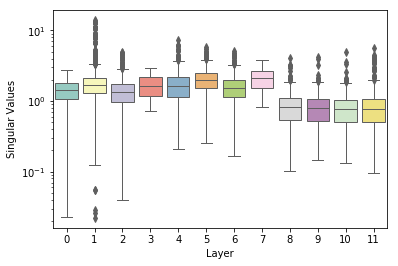

In [27]:
s = get_singular_values(trainer)
all_sigmas = np.concatenate(s)
all_layers = np.concatenate([len(s[i])*[i] for i in range(len(s))])
df = pd.DataFrame({'Singular Values':all_sigmas,'Layer':all_layers})
#df = pd.DataFrame.from_dict({f'Layer {i}':s[i] for i in range(len(s))}, orient='index')
# for i in range(len(s)):
#     singulars = np.random.choice(s[i],300)
#     plt.scatter(i*np.ones_like(singulars),singulars)
#sb.violinplot(data=df,x='Layer',y='Singular Values',palette="Set3", bw=1, cut=1, linewidth=1,kde=False)
sb.boxplot(data=df,x='Layer',y='Singular Values',palette="Set3", linewidth=1)
plt.yscale('log')
# plt.xlabel("Layer")
# plt.ylabel(r"Eigenvalues")

In [23]:
from flow_ssl.invertible import iBN
for module in trainer.model.modules():
    if isinstance(module,iBN):
        print(module.weight.shape)
        print(module.weight.abs().max()/module.weight.abs().min())

In [ ]:
for mb in trainer.dataloaders['test']:
    break
inp =x=mb[0]
with torch.no_grad():
    output = trainer.model[1].body[:6](inp)
    inp_rec = trainer.model[1].body[:6].inverse(output)
((inp_rec[0] - inp[0]).norm()/(inp[0]).norm())

In [ ]:
trainer.model[1].body[5]

In [ ]:
sb.distplot(all_sigmas)
plt.xscale('log')

In [ ]:
for i in range(len(s)):
    sb.distplot(s[i],kde=False,label=i)
#plt.yscale('log')
plt.xscale('log')
plt.legend()

In [ ]:
h = 32
channels = 32
s = []
i = 0
for module in trainer.model[1].modules():
    if isinstance(module,SN):
        s_ = module._s
        i+=1
        if i==3:break
    if isinstance(module,nn.Conv2d):
        if module.weight.shape[0]>channels:
            h//=2
            channels = module.weight.shape[0]
        
#         w2 = F.pad(w,(0,h-3,0,h-3))
#         print(w2.shape)

In [ ]:
weight = module.module.weight.cpu().data.clone()#/torch.max(module._s.cpu(),torch.tensor(1.))

In [ ]:
weight = weight.data.permute((2,3,0,1)).numpy()

In [ ]:
np.pad(weight,((0,0),(0,0),(1,1),(1,1)),mode='constant').shape

In [ ]:
h,w = module.input_shape[:2]

In [ ]:
sigmas = singularValues(weight,(h+2,w+2)).reshape(-1)

In [ ]:
sb.distplot(sigmas)

In [ ]:
module.training=True
test_in = torch.zeros_like(module._u)
module._u = None
sigma_est = []
with torch.no_grad():
    for k in range(100):
        test_out = module(test_in)
        sigma_est.append(module._s)
plt.plot(sigma_est)

In [ ]:
module.input_shape

In [ ]:
%lprun -f singularValues get_singular_values(trainer)